In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-assignment-cl-ii-lab/euroSAT_train_val_test.pkl


# Importing the libraries

In [2]:
import os
import copy
import torch
import pickle
import random
import numpy as np
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Training on GPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Loading the dataset

In [4]:
with open("/kaggle/input/ml-assignment-cl-ii-lab/euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

# Setting the seed value as 64

In [5]:
seed_value = 64

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

# Exploring the dataset

In [6]:
print(type(train_set))

print(len(train_set[0]))
print(type(train_set[0]))
print(type(train_set[0][0]))
print(train_set[0][0].shape)
print(train_set[0][1])

print(len(train_set[1]))
print(type(train_set[1]))
print(train_set[1][0].shape)
print(train_set[1][1])

<class 'list'>
2
<class 'tuple'>
<class 'numpy.ndarray'>
(3, 64, 64)
7
2
<class 'tuple'>
(3, 64, 64)
4


# Loading the dataset using DataLoader

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Setting the label mappings

In [8]:
labels_map = {0: 'AnnualCrop', 
              1: 'Forest', 
              2: 'HerbaceousVegetation', 
              3: 'Highway', 
              4: 'Industrial', 
              5: 'Pasture', 
              6: 'PermanentCrop', 
              7: 'Residential', 
              8: 'River', 
              9: 'SeaLake'}

y_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y_display_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Creating the Convolutional Neural Network Architecture

In [9]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.flatten = nn.Flatten()

        self.linear_layers = nn.Sequential(
            nn.Linear(4*4*192, 1024),
            nn.ReLU(),

            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.flatten(x)
        logits = self.linear_layers(x)
        return logits

# Function to Train the CNN Model

In [10]:
def train(model, device, train_loader, val_loader, criterion, optimizer, patience):
    # list to store the training and validation loss and accuracy after each epoch
    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()
    
    best_loss = float('inf')
    best_model = None
    epoch = 0
    k = 0
    while k < patience:  # loop over the dataset
        
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss and correct predictions
            train_loss += loss.item()
            train_correct += pred.eq(labels.view_as(pred)).sum().item()
        
        train_loss /= len(train_loader.dataset)
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(accuracy)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + loss
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            loss = criterion(outputs, labels)
            
            # calculate the loss and correct predictions
            val_loss += loss.item()
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
            
        
        val_loss /= len(val_loader.dataset)
        accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(accuracy)
        
        # implementing early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)
            k = 0
        else:
            k += 1
        
        epoch += 1
        
        print(f'[Epoch {epoch}] Train loss: {train_loss:.4f}  Validation loss: {val_loss:.4f}')
        
    return best_model, train_losses, train_accs, val_losses, val_accs

# Function to calculate Accuracy of a Model on a Dataset

In [11]:
def find_accuracy(model, device, data_loader, dataset_type):
    model.eval()
    correct = 0
    
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

    print(f'{dataset_type} Accuracy: {correct}/{len(data_loader.dataset)} ({100. * correct / len(data_loader.dataset):.3f}%)')

# Implement Early Stopping with k(patience) = 5

Learning Rate: 0.00045
[Epoch 1] Train loss: 0.0234  Validation loss: 0.0166
[Epoch 2] Train loss: 0.0155  Validation loss: 0.0130
[Epoch 3] Train loss: 0.0123  Validation loss: 0.0130
[Epoch 4] Train loss: 0.0109  Validation loss: 0.0100
[Epoch 5] Train loss: 0.0101  Validation loss: 0.0099
[Epoch 6] Train loss: 0.0095  Validation loss: 0.0088
[Epoch 7] Train loss: 0.0086  Validation loss: 0.0080
[Epoch 8] Train loss: 0.0086  Validation loss: 0.0086
[Epoch 9] Train loss: 0.0081  Validation loss: 0.0072
[Epoch 10] Train loss: 0.0076  Validation loss: 0.0084
[Epoch 11] Train loss: 0.0072  Validation loss: 0.0070
[Epoch 12] Train loss: 0.0067  Validation loss: 0.0072
[Epoch 13] Train loss: 0.0062  Validation loss: 0.0070
[Epoch 14] Train loss: 0.0059  Validation loss: 0.0067
[Epoch 15] Train loss: 0.0056  Validation loss: 0.0067
[Epoch 16] Train loss: 0.0052  Validation loss: 0.0061
[Epoch 17] Train loss: 0.0049  Validation loss: 0.0057
[Epoch 18] Train loss: 0.0045  Validation loss: 0.0

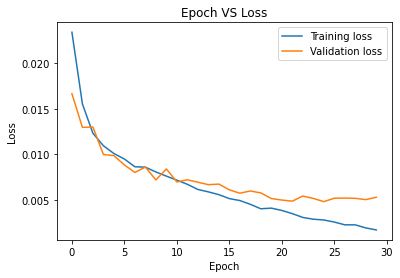

In [58]:
k = 5

for learning_rate in [0.00045]:
    model = ConvolutionalNeuralNetwork()
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    # print(model)
    
    print(f'Learning Rate: {learning_rate}')
    model, train_losses, train_accs, val_losses, val_accs = train(model, device, train_loader, val_loader, criterion, optimizer, k)
    
    find_accuracy(model, device, train_loader, 'Train')
    find_accuracy(model, device, val_loader, 'Validation')
    
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Epoch VS Loss")
    plt.legend()
    plt.show()
    
    print()
    print()

# Save the Trained Model corresponding to the Minimum Validation Loss

In [40]:
torch.save(model, '/kaggle/working/model.pth')

# Load the Saved Model

In [41]:
model = torch.load('/kaggle/working/model.pth')

# Report the Accuracy on the Validation and Test Set

In [60]:
find_accuracy(model, device, val_loader, 'Validation')
find_accuracy(model, device, test_loader, 'Test')

Validation Accuracy: 2532/2808 (90.171%)
Test Accuracy: 4845/5400 (89.722%)


# Plot of Loss on the Training and Validation Sets

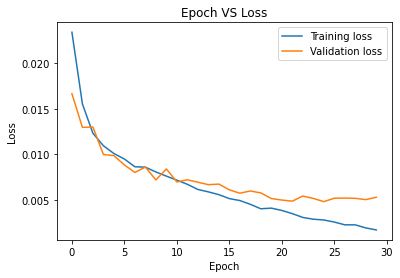

In [61]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Epoch VS Loss")
plt.legend()
plt.show()

# Plot of Accuracy on the Training and Validation Sets

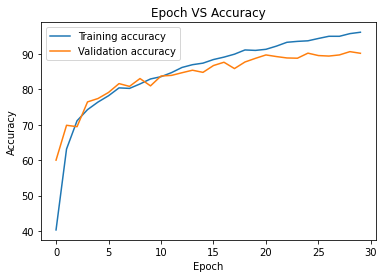

In [62]:
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Epoch VS Accuracy")
plt.legend()
plt.show()

# Plot of Confusion Matrix Heatmap on the Test Set

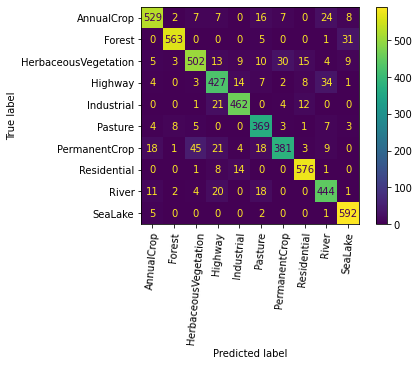

In [63]:
true_labels = torch.tensor([])
pred_labels = torch.tensor([])

model.eval()
for i, data in enumerate(test_loader, 0):
    inputs, labels = data[0].to(device), data[1]
    outputs = model(inputs)
    preds = outputs.argmax(dim=1).cpu().detach()
    true_labels = torch.cat((true_labels, labels), dim=0)
    pred_labels = torch.cat((pred_labels, preds), dim=0)

cm = confusion_matrix(true_labels, pred_labels, labels=y_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_display_labels)
disp.plot(xticks_rotation=85)
plt.show()

# Store the Predictions in a File

In [46]:
with open('/kaggle/working/task1_predictions.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(pred_labels)):
        f.write(f'{i},{int(pred_labels[i])}\n')